In [1]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

import random
import tensorflow as tf
import os
# 固定隨機種子
SEED = 401
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

2025-02-10 23:06:02.350752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 23:06:03.143718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-10 23:06:03.143849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-10 23:06:03.143859: W tensorflow/compiler/tf2tensorrt/util

产生数据

In [2]:
raw_num = 240
col_num = 2000

class Data(object):
    
    def __init__(self):
        self.data = self.get_data()
        self.label = self.get_label()
        
    def file_list(self):
        return os.listdir('data/')
    
    def get_data(self):
        file_list = self.file_list()
        for i in range(len(file_list)):
            file = scio.loadmat('data/{}'.format(file_list[i]))
            for k in file.keys():
                file_matched = re.match('X\d{3}_DE_time', k)
                if file_matched:
                    key = file_matched.group()
            if i == 0:
                data = np.array(file[key][0:480000].reshape(raw_num,col_num))
            else:
                data = np.vstack((data, file[key][0:480000].reshape((raw_num,col_num))))
        return data
    
    def get_label(self):
        file_list = self.file_list()
        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)
        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))
        return label.flatten()

In [3]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

In [4]:
y, label

(array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 array(['125', '125', '125', ..., '112', '112', '112'], dtype='<U3'))

In [5]:
data.shape, y.shape

((2400, 2000), (2400, 10))

In [33]:
np.arange(3*4*5).reshape(3,4,5).ndim

3

In [34]:
[3] * 5

[3, 3, 3, 3, 3]

In [ ]:
import math
math.prod()

In [35]:
import math
math.prod(np.asarray([3]* 5))

243

In [6]:
# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)
# data_wiener = data
# data_wiener = data

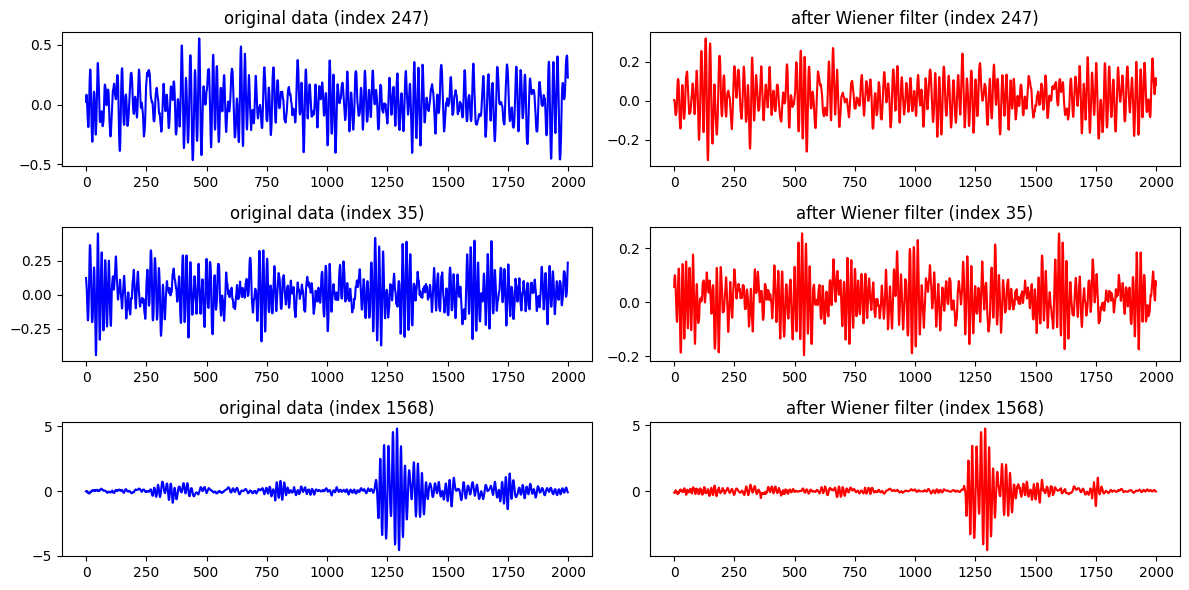

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# 隨機選擇三個索引
indices = np.random.choice(data.shape[0], size=3, replace=False)

# 視覺化原始數據與 Wiener 處理後的數據
plt.figure(figsize=(12, 6))

for i, index in enumerate(indices):
    # 顯示原始數據
    plt.subplot(3, 2, 2*i+1)
    plt.plot(data[index, :], color='blue')
    plt.title(f'original data (index {index})')
    
    # 顯示 Wiener 處理後的數據
    plt.subplot(3, 2, 2*i+2)
    plt.plot(data_wiener[index, :], color='red')
    plt.title(f'after Wiener filter (index {index})')

plt.tight_layout()
plt.show()

In [8]:
y[indices]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [9]:
# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)

(2400, 250)


In [10]:
# X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3, random_state=SEED)
# X_train = data_samp[:1680]
# X_test = data_samp[1680:]
# y_train = y[:1680]
# y_test = y[1680:]

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1680, 250), (720, 250), (1680, 10), (720, 10))

In [12]:
# 切分一部分 X_train 作為驗證集
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
X_train_sub.shape, X_val.shape, X_test.shape, y_train_sub.shape, y_val.shape, y_test.shape

((1344, 250), (336, 250), (720, 250), (1344, 10), (336, 10), (720, 10))

In [13]:
def built_model():
    
    input_seq = Input(shape=(250,))
    X = Reshape((1,250))(input_seq)
    
    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec1_layer2)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh',
                      data_format='channels_first')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_first')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_first')(ec2_layer5)
    
    encoder = multiply([ec1_outputs, ec2_outputs])
    
    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)
    
    model = Model(input_seq, dc_layer4)
    
    return model

In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [15]:
import time
begain_time = time.time()

In [16]:
model = built_model()
opt = Adam(lr=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

2025-02-10 23:06:06.135079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 23:06:06.143521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 23:06:06.143806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 23:06:06.144396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 250)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 50, 245)      350         ['reshape[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 40, 240)      12040       ['conv1d_2[0][0]']               
                                                                                              

/home/kycho/vad-code/.conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# 設定 EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # 監測驗證集的 loss
    patience=15,          # 若 10 個 epochs 都沒有改善，就停止訓練
    restore_best_weights=True  # 讓模型回到最佳狀態
)

In [18]:
# history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=400, 
#                     verbose=2, validation_split=0.2,
#                     shuffle=True, initial_epoch=0)

# 訓練模型
history = model.fit(
    x=X_train_sub, y=y_train_sub, 
    batch_size=100, epochs=400, 
    verbose=2, validation_data=(X_val, y_val),
    shuffle=True, initial_epoch=0,
    callbacks=[early_stopping]  # 加入 EarlyStopping
)

Epoch 1/400


2025-02-10 23:06:11.177176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


14/14 - 5s - loss: 0.0900 - accuracy: 0.1012 - val_loss: 0.0900 - val_accuracy: 0.0893 - 5s/epoch - 391ms/step
Epoch 2/400
14/14 - 0s - loss: 0.0893 - accuracy: 0.1302 - val_loss: 0.0877 - val_accuracy: 0.0893 - 160ms/epoch - 11ms/step
Epoch 3/400
14/14 - 0s - loss: 0.0851 - accuracy: 0.1652 - val_loss: 0.0819 - val_accuracy: 0.1815 - 161ms/epoch - 11ms/step
Epoch 4/400
14/14 - 0s - loss: 0.0786 - accuracy: 0.2567 - val_loss: 0.0763 - val_accuracy: 0.2708 - 162ms/epoch - 12ms/step
Epoch 5/400
14/14 - 0s - loss: 0.0737 - accuracy: 0.3013 - val_loss: 0.0748 - val_accuracy: 0.2708 - 163ms/epoch - 12ms/step
Epoch 6/400
14/14 - 0s - loss: 0.0718 - accuracy: 0.3251 - val_loss: 0.0752 - val_accuracy: 0.2738 - 158ms/epoch - 11ms/step
Epoch 7/400
14/14 - 0s - loss: 0.0721 - accuracy: 0.3296 - val_loss: 0.0728 - val_accuracy: 0.3185 - 161ms/epoch - 12ms/step
Epoch 8/400
14/14 - 0s - loss: 0.0691 - accuracy: 0.3720 - val_loss: 0.0691 - val_accuracy: 0.3661 - 161ms/epoch - 12ms/step
Epoch 9/400
14

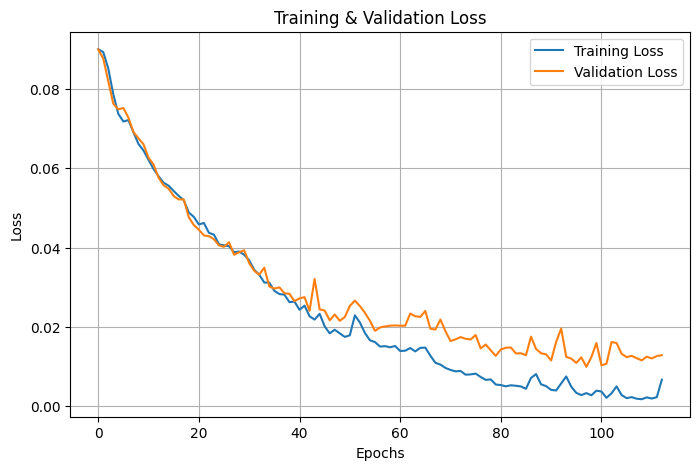

In [19]:
import matplotlib.pyplot as plt

# 繪製 loss 圖表
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

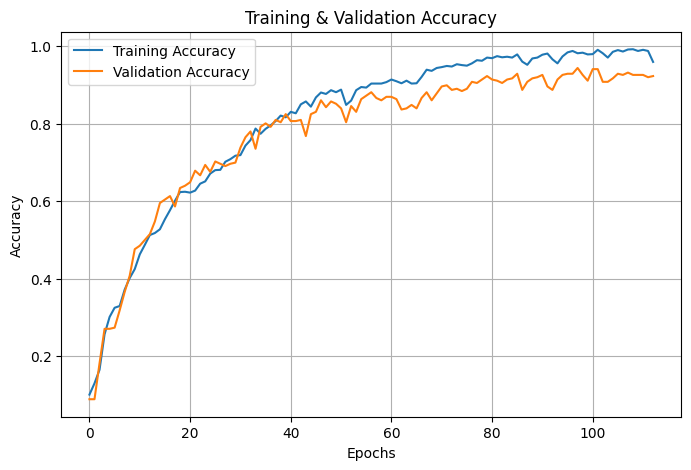

In [20]:
import matplotlib.pyplot as plt
# 繪製 accuracy 圖表
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [21]:
end_time = time.time()
time = end_time - begain_time
print('time:', time)

time: 25.91923475265503


In [22]:
# 評估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"測試集準確率: {test_acc:.4f}")

測試集準確率: 0.9528


In [23]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 取得模型的預測結果
y_pred = model.predict(X_test)  # 這會回傳機率分佈
y_pred_labels = np.argmax(y_pred, axis=1)  # 轉換為類別標籤
y_true_labels = np.argmax(y_test, axis=1)  # 如果 y_test 是 one-hot，要轉成標籤

# 計算 Precision、Recall 和 F1-score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

# 顯示結果
print(f"測試集準確率: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

23/23 [==============================] - 1s 3ms/step
測試集準確率: 0.9528
Precision: 0.9544
Recall: 0.9546
F1-score: 0.9539


23/23 [==============================] - 1s 3ms/step


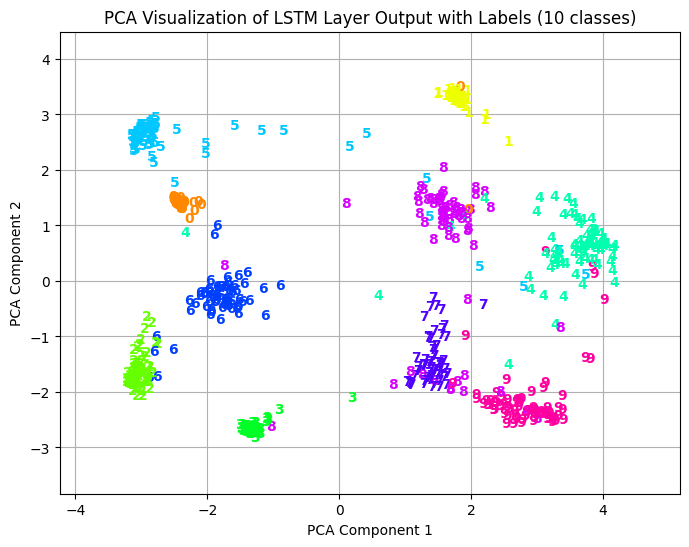

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
import seaborn as sns

# 取得 dc_layer2 的輸出 (LSTM(60) 這一層)
intermediate_layer_model = Model(inputs=model.input, 
                                 outputs=model.get_layer(index=-3).output)  # dc_layer2 是倒數第三層

# 取得 X_test 在 dc_layer2 層的特徵
X_test_features = intermediate_layer_model.predict(X_test)

# 使用 PCA 降維到 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_features)

# 取得真實標籤
y_true_labels = np.argmax(y_test, axis=1)

# 設定顏色
num_classes = len(np.unique(y_true_labels))
palette = sns.color_palette("hsv", num_classes)

# 繪製 2D PCA 散點圖（使用標籤數字）
plt.figure(figsize=(8, 6))
for i in range(len(X_test_pca)):
    # 在每個點旁邊加上標籤，並調整文字大小和位置
    plt.text(X_test_pca[i, 0] + 0.01, X_test_pca[i, 1] + 0.01, str(y_true_labels[i]),
             color=palette[y_true_labels[i]], fontsize=10, fontweight='bold',
             ha='center', va='center')

# 設定坐標範圍，避免資料跑出去
plt.xlim(X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1)
plt.ylim(X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1)

# 設置標籤和標題
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of LSTM Layer Output with Labels (10 classes)")

# 顯示圖形
plt.grid(True)
plt.show()

23/23 [==============================] - 1s 3ms/step


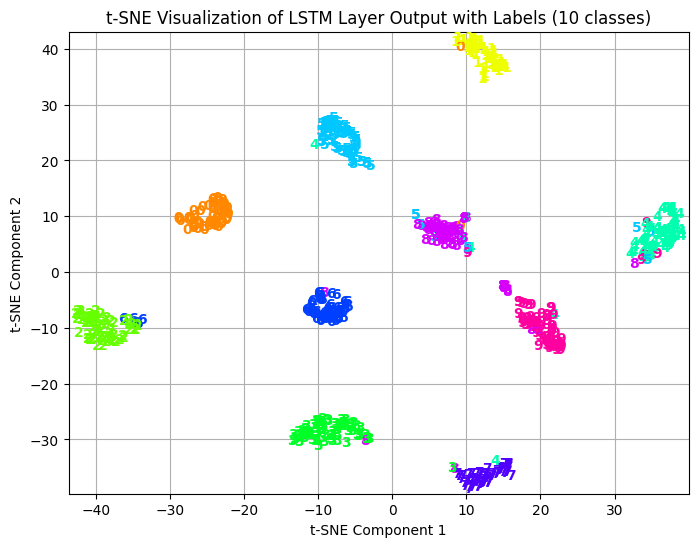

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # 更換為 t-SNE
from tensorflow.keras.models import Model
import seaborn as sns

# 取得 dc_layer2 的輸出 (LSTM(60) 這一層)
intermediate_layer_model = Model(inputs=model.input, 
                                 outputs=model.get_layer(index=-3).output)  # dc_layer2 是倒數第三層

# 取得 X_test 在 dc_layer2 層的特徵
X_test_features = intermediate_layer_model.predict(X_test)

# 使用 t-SNE 降維到 2D
tsne = TSNE(n_components=2, random_state=42)  # 使用 t-SNE 代替 PCA
X_test_tsne = tsne.fit_transform(X_test_features)

# 取得真實標籤
y_true_labels = np.argmax(y_test, axis=1)

# 設定顏色
num_classes = len(np.unique(y_true_labels))
palette = sns.color_palette("hsv", num_classes)

# 繪製 2D t-SNE 散點圖（使用標籤數字）
plt.figure(figsize=(8, 6))
for i in range(len(X_test_tsne)):
    # 在每個點旁邊加上標籤，並調整文字大小和位置
    plt.text(X_test_tsne[i, 0] + 0.01, X_test_tsne[i, 1] + 0.01, str(y_true_labels[i]),
             color=palette[y_true_labels[i]], fontsize=10, fontweight='bold',
             ha='center', va='center')

# 設定坐標範圍，避免資料跑出去
plt.xlim(X_test_tsne[:, 0].min() - 1, X_test_tsne[:, 0].max() + 1)
plt.ylim(X_test_tsne[:, 1].min() - 1, X_test_tsne[:, 1].max() + 1)

# 設置標籤和標題
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of LSTM Layer Output with Labels (10 classes)")

# 顯示圖形
plt.grid(True)
plt.show()

 1/23 [>.............................] - ETA: 0s

23/23 [==============================] - 0s 3ms/step


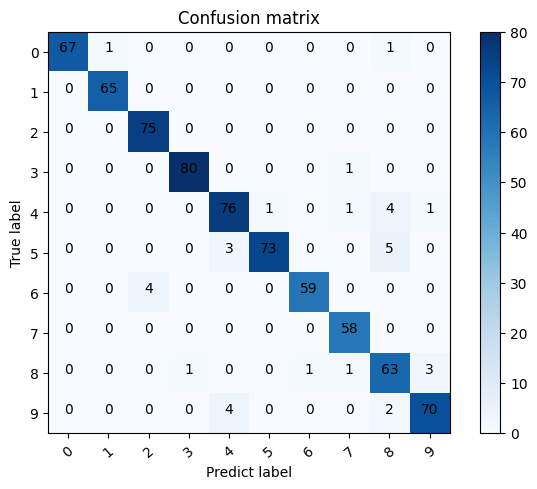

In [26]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 建立 MLP 模型
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(250,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 類別分類
])

# 編譯模型
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# 設定 EarlyStopping（監測 val_loss，若 10 個 epochs 沒改善則停止）
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 訓練模型
history = mlp_model.fit(
    X_train_sub, y_train_sub,
    batch_size=100,
    epochs=400,
    verbose=2,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[early_stopping]  # 加入 EarlyStopping
)

# 繪製訓練過程
plt.figure(figsize=(12, 5))

# 繪製 Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# 繪製 Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 取得模型的預測結果
y_pred = mlp_model.predict(X_test)  # 這會回傳機率分佈
y_pred_labels = np.argmax(y_pred, axis=1)  # 轉換為類別標籤
y_true_labels = np.argmax(y_test, axis=1)  # 如果 y_test 是 one-hot，要轉成標籤

# 計算 Precision、Recall 和 F1-score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

# 顯示結果
print(f"測試集準確率: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
import seaborn as sns

# 建立一個新的模型，只取出 Dense(64) 層的輸出
intermediate_layer_model_mlp = Model(inputs=mlp_model.input,
                                      outputs=mlp_model.get_layer(index=3).output)  # Dense(64) 是第四層 (index=3)

# 取得 X_test 在 Dense(64) 層的特徵
X_test_features_mlp = intermediate_layer_model_mlp.predict(X_test)

# 使用 PCA 降維到 2D
pca_mlp = PCA(n_components=2)
X_test_pca_mlp = pca_mlp.fit_transform(X_test_features_mlp)

# 取得真實標籤
y_true_labels_mlp = np.argmax(y_test, axis=1)

# 設定顏色
num_classes_mlp = len(np.unique(y_true_labels_mlp))
palette_mlp = sns.color_palette("hsv", num_classes_mlp)

# 繪製 2D PCA 散點圖（使用標籤數字）
plt.figure(figsize=(8, 6))
for i in range(len(X_test_pca_mlp)):
    # 在每個點旁邊加上標籤，並調整文字大小和位置
    plt.text(X_test_pca_mlp[i, 0] + 0.01, X_test_pca_mlp[i, 1] + 0.01, str(y_true_labels_mlp[i]),
             color=palette_mlp[y_true_labels_mlp[i]], fontsize=10, fontweight='bold',
             ha='center', va='center')

# 設定坐標範圍，避免資料跑出去
plt.xlim(X_test_pca_mlp[:, 0].min() - 1, X_test_pca_mlp[:, 0].max() + 1)
plt.ylim(X_test_pca_mlp[:, 1].min() - 1, X_test_pca_mlp[:, 1].max() + 1)

# 設置標籤和標題
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Dense(64) Layer Output with Labels (10 classes)")

# 顯示圖形
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
import seaborn as sns

# 建立一個新的模型，只取出 Dense(64) 層的輸出
intermediate_layer_model_mlp = Model(inputs=mlp_model.input,
                                      outputs=mlp_model.get_layer(index=3).output)  # Dense(64) 是第四層 (index=3)

# 取得 X_test 在 Dense(64) 層的特徵
X_test_features_mlp = intermediate_layer_model_mlp.predict(X_test)

# 使用 t-SNE 降維到 2D
tsne_mlp = TSNE(n_components=2, random_state=42)
X_test_tsne_mlp = tsne_mlp.fit_transform(X_test_features_mlp)

# 取得真實標籤
y_true_labels_mlp = np.argmax(y_test, axis=1)

# 設定顏色
num_classes_mlp = len(np.unique(y_true_labels_mlp))
palette_mlp = sns.color_palette("hsv", num_classes_mlp)

# 繪製 2D t-SNE 散點圖（使用標籤數字）
plt.figure(figsize=(8, 6))
for i in range(len(X_test_tsne_mlp)):
    # 在每個點旁邊加上標籤，並調整文字大小和位置
    plt.text(X_test_tsne_mlp[i, 0] + 0.01, X_test_tsne_mlp[i, 1] + 0.01, str(y_true_labels_mlp[i]),
             color=palette_mlp[y_true_labels_mlp[i]], fontsize=10, fontweight='bold',
             ha='center', va='center')

# 設定坐標範圍，避免資料跑出去
plt.xlim(X_test_tsne_mlp[:, 0].min() - 1, X_test_tsne_mlp[:, 0].max() + 1)
plt.ylim(X_test_tsne_mlp[:, 1].min() - 1, X_test_tsne_mlp[:, 1].max() + 1)

# 設置標籤和標題
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Dense(64) Layer Output with Labels (10 classes)")

# 顯示圖形
plt.grid(True)
plt.show()

In [ ]:
SEED = 42
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 假設你的數據是 NumPy 陣列
# X.shape = (samples, 250), y.shape = (samples, 10)
# 如果 y 是 one-hot 編碼，先轉回標籤
y_label = np.argmax(y, axis=1)  # 轉換 one-hot 為標籤格式

# 切分訓練集、驗證集、測試集 (80% 訓練, 20% 測試)
X_train, X_test, y_train, y_test = train_test_split(data_samp, y_label, test_size=0.3, random_state=SEED)

# 再切分 20% 的訓練集作為驗證集
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# 初始化不同的分類模型
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "SVM": SVC(kernel='rbf', probability=True),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
}

# 訓練並評估每個模型
for name, model in models.items():
    print(f"\n訓練 {name} 模型...")
    model.fit(X_train_sub, y_train_sub)

    # 預測驗證集
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} 驗證集準確率: {val_acc:.4f}")

    # 預測測試集
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"{name} 測試集準確率: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))

# 繪製比較不同模型的測試準確率
test_accs = [accuracy_score(y_test, model.predict(X_test)) for model in models.values()]

plt.figure(figsize=(8, 5))
plt.bar(models.keys(), test_accs, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('不同機器學習模型的測試準確率')
plt.ylim(0, 1)
plt.show()